In [1]:
import numpy as np
import pandas as pd
import FdsPy.qe.myqengine as qe
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates

sns.set_theme(style="darkgrid")

### Query Data in QE

In [2]:
time_series = qe.TimeSeries(start_date = '-11M',end_date = '0M', frequency='M',calendar='NAY')

univ = qe.IdUniverse(ids = ['AAPL-US','META-US','AMZN-US','NVDA-US','GOOGL-US','MSFT-US','TSLA-US'],universe_type='Equity')
out_data = {}
for fy in ['1','2','3']:
    data_dict = {"Broker Name":f"FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,ANN,+{fy},#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                'Analyst Name':f"FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,ANN,+{fy},#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')",
                f"EST_EPS_FY{fy}":f"FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,ANN,+{fy},#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')",
                "Research Date":f"FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,ANN,+{fy},'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')",
                "Analyst ID":f"FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,ANN,+{fy},#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                "Cumulative Return":"P_PRICE_RETURNS(1,20220831,#DATE,RANGE,USD)", 
                "Report Date":"FE_ESTIMATE_DATE(RPT_DATE,,QTR_ROLL,+1,'YYYYMMDD',#DATE,,,'')",
                "Surprise":"FE_SURPRISE(PERCENT,EPS,MEAN,QTR_ROLL,0,#DATE,,,'')",
                }
    req = qe.Calculation(universe = univ, dates = time_series,data_dict=data_dict,
                                            source = 'FqlExpression',
                                            is_array=True).query()
    out_data[fy]= req.data


### Explode Broker Detail Arrays and Clean Data

In [3]:
df_full =pd.DataFrame()
for fy in ['1','2','3']:
    df = out_data[fy].iloc[:,:7].set_index('UNIVERSE')
    
    df_temp = pd.concat([df['Analyst ID'].explode().reset_index()[['UNIVERSE','Analyst ID']],
                         df['Broker Name'].explode().reset_index().iloc[:,-1:],
                         df['Analyst Name'].explode().reset_index().iloc[:,-1:],
                         df[f'EST_EPS_FY{fy}'].explode().reset_index().iloc[:,-1:],
                         df['Research Date'].explode().reset_index().iloc[:,-1:]],axis=1)
    for column in ['Analyst ID','Broker Name','Analyst Name',f'EST_EPS_FY{fy}','Research Date']:
        df_temp[column] = df_temp[column].replace('@NA',np.nan)
    df_temp = df_temp.dropna()
    df_temp['DATE'] = pd.to_datetime(df_temp['Research Date'])
    df_temp = df_temp.groupby(['DATE','Broker Name','UNIVERSE']).agg({f'EST_EPS_FY{fy}':'mean'})
    df_full = pd.concat([df_full,df_temp])

In [4]:
df_full =df_full.groupby(['DATE','Broker Name','UNIVERSE']).agg({df_full.columns[0]:'last',
                                                       df_full.columns[1]:'last',
                                                       df_full.columns[2]:'last',
                                                       })

In [5]:
df_full.head()

EST_EPS_FY1  EST_EPS_FY2  \
DATE       Broker Name                UNIVERSE                             
2022-09-01 Argus Research             NVDA-US      4.990000          NaN   
           Cleveland Research Company GOOGL-US     6.342016          NaN   
           Edgewater Research         GOOGL-US     6.170000          NaN   
           Jefferies                  NVDA-US      5.220000          NaN   
           Piper Sandler Companies    NVDA-US      4.690000          NaN   

                                                EST_EPS_FY3  
DATE       Broker Name                UNIVERSE               
2022-09-01 Argus Research             NVDA-US           NaN  
           Cleveland Research Company GOOGL-US          NaN  
           Edgewater Research         GOOGL-US          NaN  
           Jefferies                  NVDA-US           NaN  
           Piper Sandler Companies    NVDA-US           NaN

### Clean Security Level Data

In [6]:
df_s = out_data[fy].set_index(['DATE','UNIVERSE']).iloc[:,5:].reset_index()
df_s['DATE'] = pd.to_datetime(df_s['DATE']).apply(lambda x:x.strftime("%m/%d/%Y"))
df_s['Cumulative Return']= df_s['Cumulative Return'].apply(lambda x:x[0])
df_s['Report Date']= pd.to_datetime(df_s['Report Date'].apply(lambda x: x[0]))
df_s['Surprise']= df_s['Surprise'].apply(lambda x: x[0]).astype(float)
df_s = df_s.set_index(['DATE','UNIVERSE'])
df_s

Cumulative Return Report Date    Surprise
DATE       UNIVERSE                                           
09/30/2022 AAPL-US          -12.097698  2022-10-28    3.136958
           META-US          -16.724974  2022-10-27   -3.041948
           AMZN-US          -10.862189  2022-10-28 -266.810460
           NVDA-US          -19.550817  2022-11-17    2.180218
           GOOGL-US         -11.615229  2022-10-26   -4.422052
...                                ...         ...         ...
08/31/2023 AMZN-US            8.866453  2023-10-26   83.663170
           NVDA-US          227.090210  2023-11-22   29.693375
           GOOGL-US          25.827015  2023-10-24    7.134389
           MSFT-US           26.393080  2023-10-25    5.464335
           TSLA-US           -6.360436  2023-10-18   12.379536

[84 rows x 3 columns]

### Plot Data

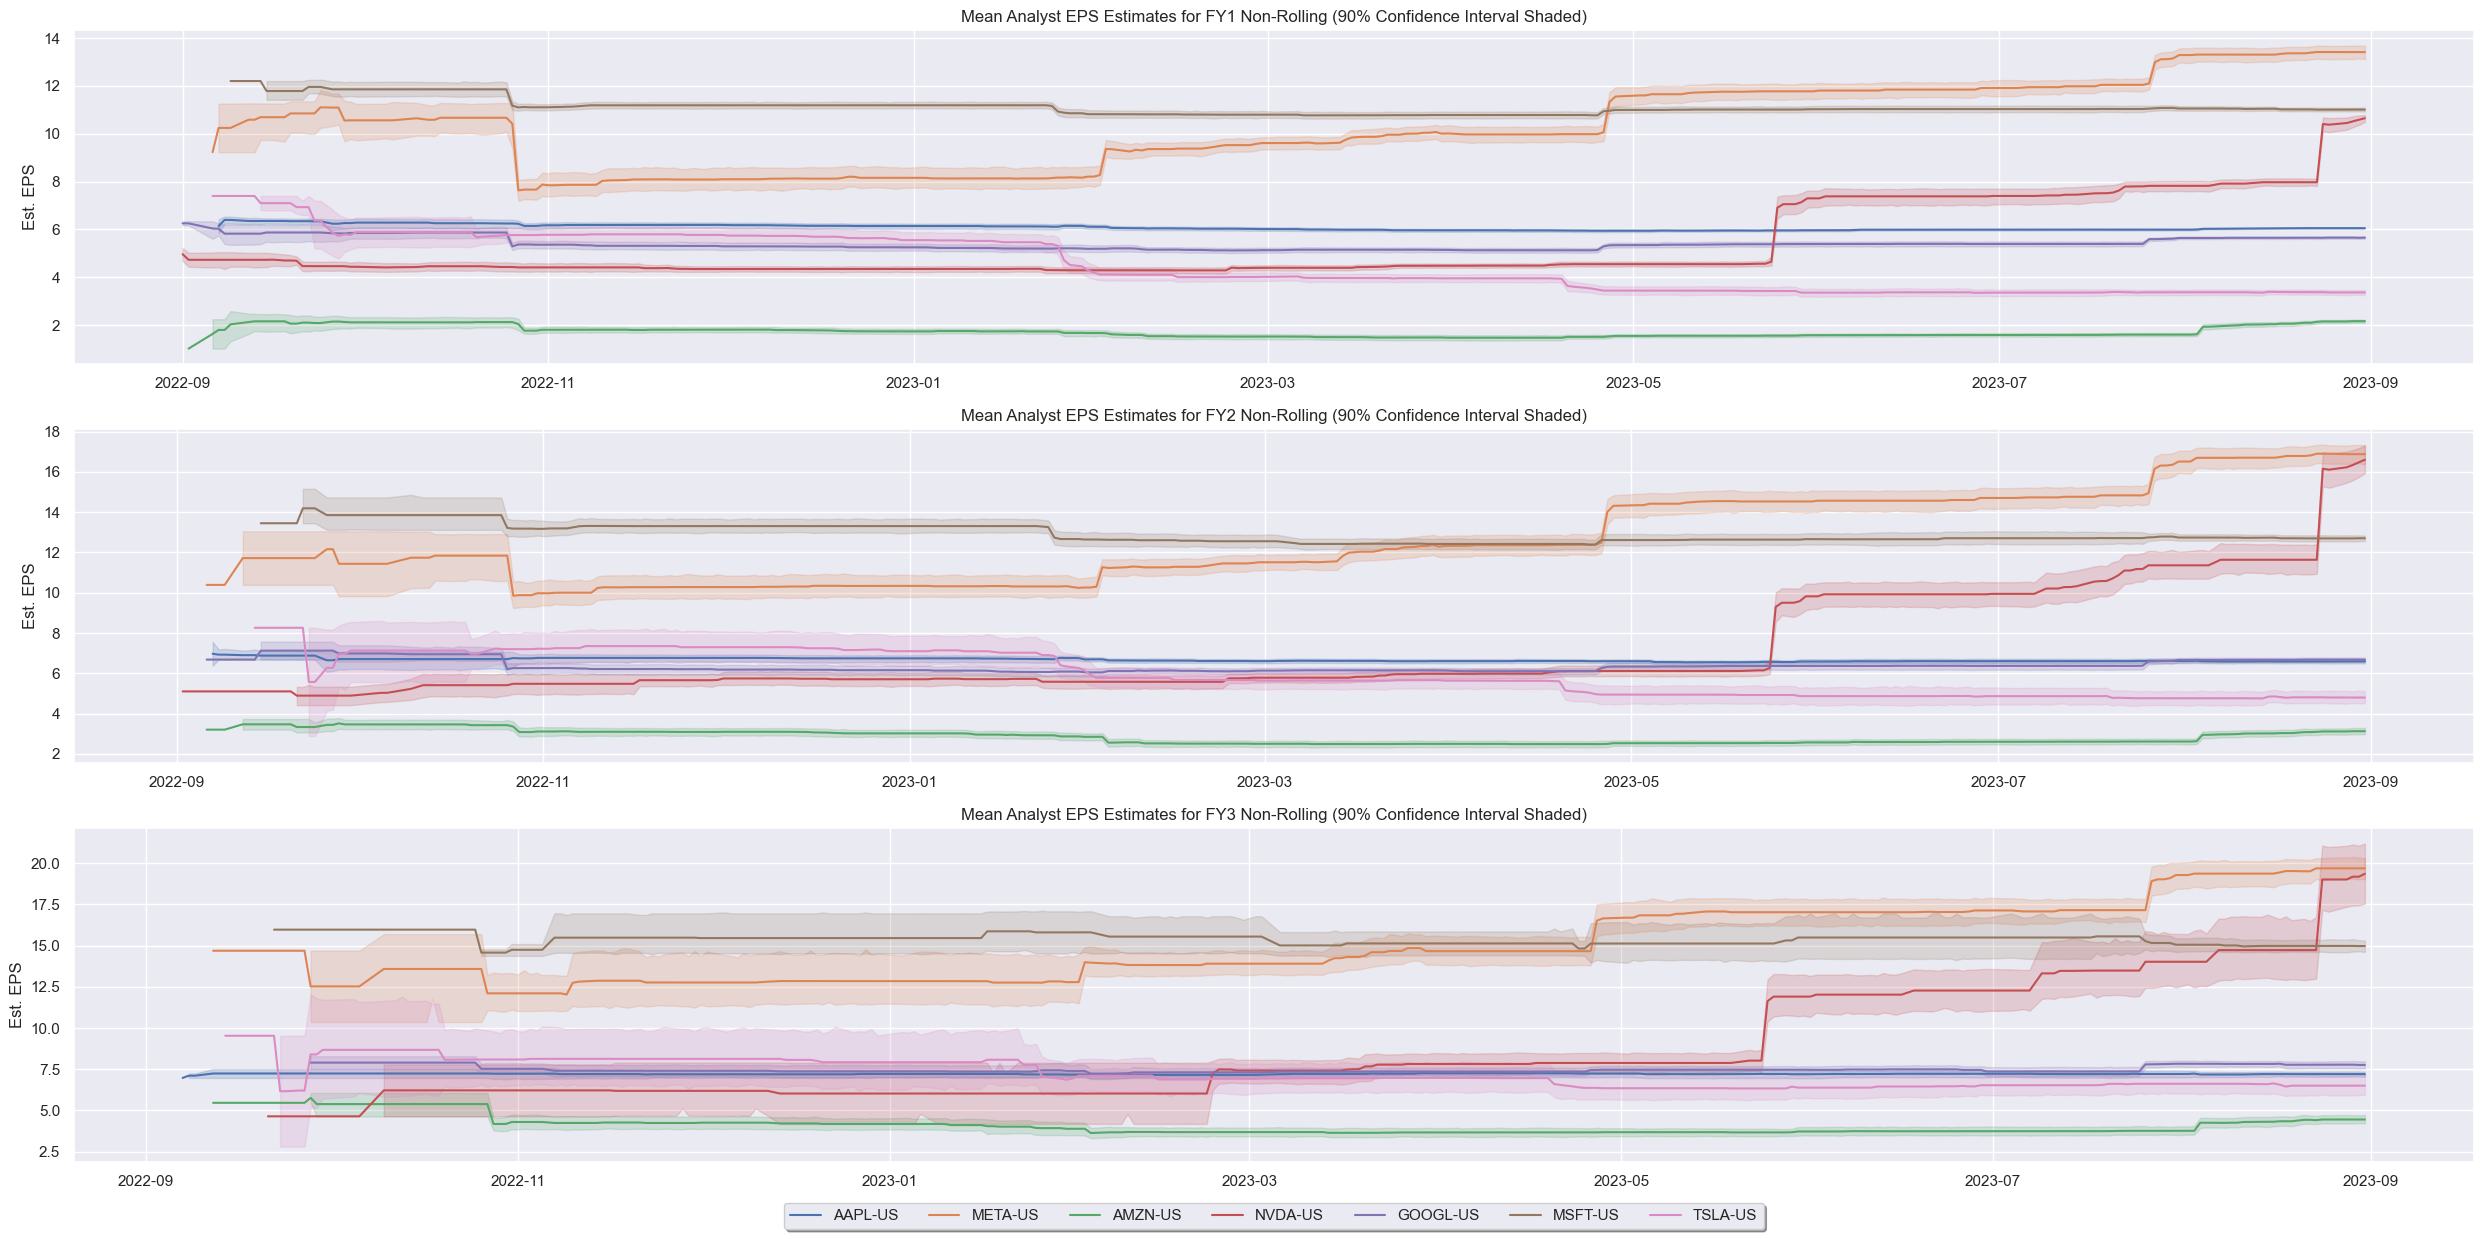

In [7]:
fig,axs = plt.subplots(3,1,figsize = (25,12.5))

sns.lineplot(df_full['EST_EPS_FY1'].unstack().unstack().ffill(limit = 90).stack().stack().rename('EST_EPS_FY1').reset_index(),
                x = 'DATE',y = 'EST_EPS_FY1',hue = 'UNIVERSE',ax=axs[0],hue_order = list(df_s.index.get_level_values(1).unique()))
axs[0].set_title('Mean Analyst EPS Estimates for FY1 Non-Rolling (90% Confidence Interval Shaded)')
axs[0].set_ylabel('Est. EPS')
axs[0].get_legend().remove()
axs[0].set_xlabel('')
sns.lineplot(df_full['EST_EPS_FY2'].unstack().unstack().ffill(limit = 90).stack().stack().rename('EST_EPS_FY2').reset_index(),
                x = 'DATE',y = 'EST_EPS_FY2',hue = 'UNIVERSE',ax=axs[1],hue_order = list(df_s.index.get_level_values(1).unique()))
axs[1].set_title('Mean Analyst EPS Estimates for FY2 Non-Rolling (90% Confidence Interval Shaded)')
axs[1].set_ylabel('Est. EPS')
axs[1].get_legend().remove()
axs[1].set_xlabel('')
sns.lineplot(df_full['EST_EPS_FY3'].unstack().unstack().ffill(limit = 90).stack().stack().rename('EST_EPS_FY3').reset_index(),
                x = 'DATE',y = 'EST_EPS_FY3',hue = 'UNIVERSE',ax=axs[2],hue_order = list(df_s.index.get_level_values(1).unique()))
axs[2].set_title('Mean Analyst EPS Estimates for FY3 Non-Rolling (90% Confidence Interval Shaded)')
axs[2].set_ylabel('Est. EPS')
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -.1),
          ncol=7, fancybox=True, shadow=True)

axs[2].set_xlabel('')
plt.savefig('mag7_eps_annual_forward.png')

plt.tight_layout()

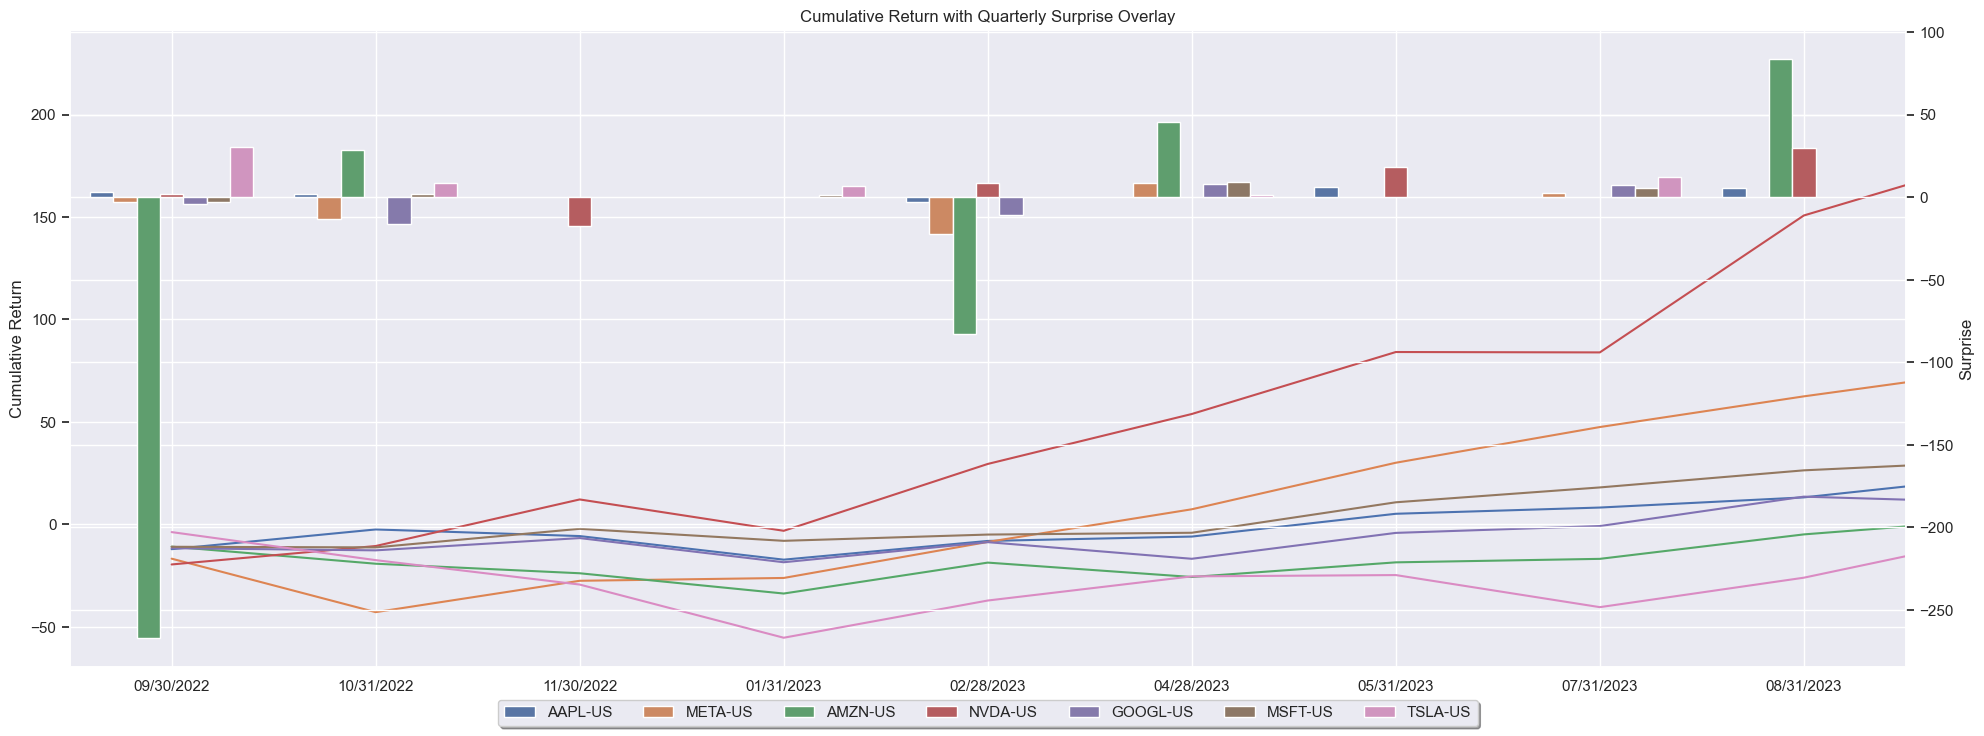

In [8]:
fig,ax = plt.subplots(figsize=(20,7.5),)

sns.lineplot(df_s.reset_index(),
                x = 'DATE',y = 'Cumulative Return',hue = 'UNIVERSE',hue_order = list(df_s.index.get_level_values(1).unique()),ax = ax)

#plt.savefig('magnificant_7_FYE1_Broker_EPS_Estimates.png', format='png', dpi=100)
ax2 = ax.twinx()
ax.get_legend().remove()
df_plt = df_s.reset_index()
sns.barplot(data=df_plt[['UNIVERSE','Surprise','DATE']].drop_duplicates('Surprise'),x='DATE',y='Surprise',hue='UNIVERSE',ax=ax2,hue_order = list(df_s.index.get_level_values(1).unique()))
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -.04),
          ncol=7, fancybox=True, shadow=True)
plt.subplots_adjust(hspace = 1.5)
plt.title("Cumulative Return with Quarterly Surprise Overlay")
plt.savefig('mag7_cumulative_ret_with_q_surprise.png')
plt.tight_layout()

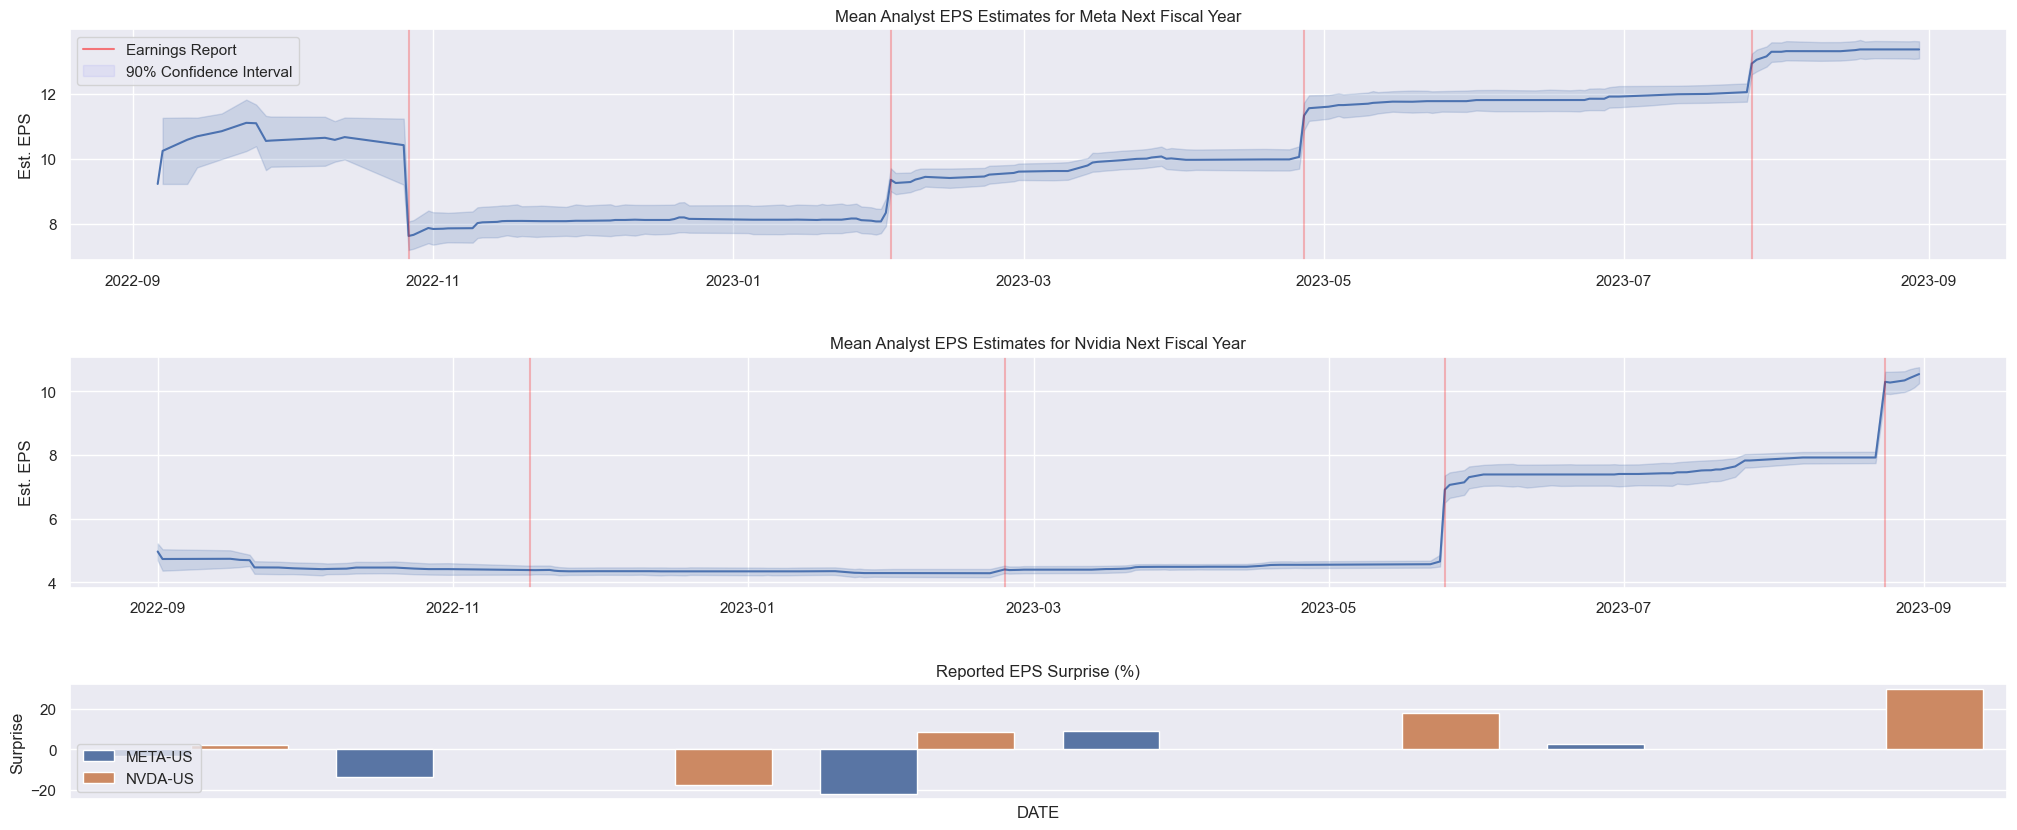

In [9]:
fig,axs = plt.subplots(3,1,figsize=(25,10),gridspec_kw={'height_ratios': [2,2, 1]})
# Create a patch for the 90% confidence interval
confidence_patch = mpatches.Patch(color='blue', label='90% Confidence Interval',alpha =.05)

# Create a line for the Quarterly Report
line = mlines.Line2D([], [], color='red', label='Earnings Report',alpha = .5)


df_mn = df_full.reset_index()[df_full.reset_index()['UNIVERSE'].isin(['META-US'])].set_index(['DATE','Broker Name','UNIVERSE'])
sns.lineplot(data=df_mn['EST_EPS_FY1'].unstack().unstack().ffill(limit = 45).stack().stack().rename('EST_EPS_FY1').reset_index(), x='DATE', y='EST_EPS_FY1',hue='UNIVERSE', ax=axs[0])

for report_date in list(df_s.xs('META-US',level=1)['Report Date'].unique())[:-1]:
    axs[0].axvline(report_date, color = 'red', label = 'Quarterly Report',alpha = .25)
axs[0].set_xlabel('')
axs[0].set_title('Mean Analyst EPS Estimates for Meta Next Fiscal Year')
axs[0].get_legend().remove()
axs[0].set_ylabel('Est. EPS')
axs[0].legend(handles=[line, confidence_patch])
#sns.barplot(df_n.iloc[:,1].reset_index(),ax=axs[0],x='Date',y='NVDA-US')
df_mn = df_full.reset_index()[df_full.reset_index()['UNIVERSE'].isin(['NVDA-US'])].set_index(['DATE','Broker Name','UNIVERSE'])
sns.lineplot(data=df_mn['EST_EPS_FY1'].unstack().unstack().ffill(limit = 45).stack().stack().rename('EST_EPS_FY1').reset_index(), x='DATE', y='EST_EPS_FY1', hue='UNIVERSE', ax=axs[1])

for report_date in list(df_s.xs('NVDA-US',level=1)['Report Date'].unique())[:-1]:
    axs[1].axvline(report_date, color = 'red', label = 'Quarterly Report',alpha = .25)
axs[1].set_xlabel('')
axs[1].set_title('Mean Analyst EPS Estimates for Nvidia Next Fiscal Year')
axs[1].get_legend().remove()
axs[1].set_ylabel('Est. EPS')

df_temp2 = df_s.reset_index()
df_temp2 = df_temp2[df_temp2['UNIVERSE'].isin(['META-US','NVDA-US'])]
sns.barplot(data=df_temp2[['UNIVERSE','Surprise','DATE']].drop_duplicates('Surprise'),x='DATE',y='Surprise',hue='UNIVERSE',ax=axs[2])
locator = mdates.MonthLocator()  # every month
axs[2].xaxis.set_major_locator(locator)
fmt = mdates.DateFormatter('%b')
axs[2].xaxis.set_major_formatter(fmt)
axs[2].set_title('Reported EPS Surprise (%)')
axs[2].set_xticks([])
axs[2].legend(loc='lower left')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('mag7_META_NVIDIA_Q_SURPRISE.png', format='png', dpi=100)
